In [59]:
import warnings
warnings.filterwarnings('ignore')

In [60]:
import numpy as np
import pandas as pd
import re, random, time
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_colwidth = 1000

In [61]:
df_train = pd.read_csv('train.csv', encoding="ISO-8859-1")
df_train['train'] = 1
df_test = pd.read_csv('test.csv', encoding="ISO-8859-1")
df_test['train'] = 0
df_all = df_train.append(df_test)
print(df_test.shape, df_train.shape, df_all.shape)

OHE_columns = [x for x in df_all.columns if x == 'sourcing_channel']
df_all = pd.get_dummies(df_all, columns= OHE_columns)
df_all.residence_area_type = pd.factorize(df_all.residence_area_type)[0]
# df_all.drop('sourcing_channel', axis = 1, inplace = True)
# df_all.sourcing_channel = pd.factorize(df_all.sourcing_channel)[0]
df_all.head(2)

(34224, 13) (79853, 14) (114077, 14)


,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,Income,age_in_days,application_underwriting_score,id,no_of_premiums_paid,perc_premium_paid_by_cash_credit,premium,renewal,residence_area_type,train,sourcing_channel_A,sourcing_channel_B,sourcing_channel_C,sourcing_channel_D,sourcing_channel_E
0,0.0,0.0,0.0,355060,12058,99.02,110936,13,0.429,3300,1.0,0,1,0,0,1,0,0
1,0.0,0.0,0.0,315150,21546,99.89,41492,21,0.010,18000,1.0,0,1,1,0,0,0,0


## feature engineering

In [63]:
# df_all['premium_income'] = df_all.premium.divide(df_all.Income)
df_all['amount_paid'] = df_all.no_of_premiums_paid * df_all.premium
df_train = df_all[df_all.train == 1]
df_train.reset_index(drop = True, inplace=True)
df_test = df_all[df_all.train == 0].reset_index(drop = True)
df_test.reset_index(drop = True, inplace=True)
print(df_test.shape, df_train.shape, df_all.shape)

(34224, 19) (79853, 19) (114077, 19)


## LGB

In [65]:
np.random.seed(1)
train_rows = np.random.choice(df_train.index, int(len(df_train)* 0.8), replace=False)
valid_rows = [x for x in df_train.index if x not in train_rows]
df_train1 = df_train.loc[train_rows]
df_valid1 = df_train.loc[valid_rows]

train_X = df_train1.drop(['id', 'train', 'renewal'], axis = 1)
train_Y = df_train1.renewal
valid_X = df_valid1.drop(['id', 'train', 'renewal'], axis = 1)
valid_Y = df_valid1.renewal
test_X = df_test.drop(['id', 'train', 'renewal'], axis = 1)
print(train_X.shape, train_Y.shape, test_X.shape, valid_X.shape, train_X.Income.mean())

(63882, 16) (63882,) (34224, 16) (15971, 16) 210255.552425


Training until validation scores don't improve for 200 rounds.
[20]	valid_0's auc: 0.846853
[40]	valid_0's auc: 0.847754
[60]	valid_0's auc: 0.848459
[80]	valid_0's auc: 0.848924
[100]	valid_0's auc: 0.848982
[120]	valid_0's auc: 0.84918
[140]	valid_0's auc: 0.848946
[160]	valid_0's auc: 0.849161
[180]	valid_0's auc: 0.849429
[200]	valid_0's auc: 0.849768
[220]	valid_0's auc: 0.849729
[240]	valid_0's auc: 0.849856
[260]	valid_0's auc: 0.849966
[280]	valid_0's auc: 0.849864
[300]	valid_0's auc: 0.849741
[320]	valid_0's auc: 0.84966
[340]	valid_0's auc: 0.849336
[360]	valid_0's auc: 0.848934
[380]	valid_0's auc: 0.84862
[400]	valid_0's auc: 0.848447
[420]	valid_0's auc: 0.848196
[440]	valid_0's auc: 0.848094
Early stopping, best iteration is:
[248]	valid_0's auc: 0.84997
Plot feature importances...


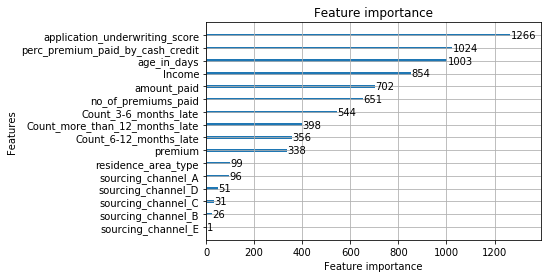

In [66]:
params = {
    'learning_rate': 0.02, 
    'boosting': 'gbdt', 
    'objective': 'binary', 
    'metric': 'auc', 
    'is_training_metric': False, 
    'scale_pos_weight': 0.5,
    'max_depth': 8,  
    'min_child_samples': 100,  
    'max_bin': 100,  
    'subsample': 0.7,  
    'subsample_freq': 1,  
    'colsample_bytree': 0.7,
    'seed': 0
}

fit_model = lgb.train( params, train_set= lgb.Dataset(train_X, label=train_Y.values), num_boost_round= 2000,
            valid_sets = lgb.Dataset(valid_X, label=valid_Y.values), verbose_eval = 20, early_stopping_rounds = 200)

valid_pred = fit_model.predict(valid_X, num_iteration=fit_model.best_iteration)
train_pred = fit_model.predict(train_X, num_iteration=fit_model.best_iteration)
test_pred = fit_model.predict(test_X, num_iteration=fit_model.best_iteration)

print('Plot feature importances...')
ax = lgb.plot_importance(fit_model, max_num_features=20)
plt.show()

In [68]:
submission = df_test[['id', 'premium']]
submission['renewal'] = test_pred
submission.head(2)

,id,premium,renewal
0,649,3300,0.979379
1,81136,11700,0.967940


## Incentive calculation

In [70]:
'''
Equation for the effort-incentives curve: effort = 10*(1-exp(-incentive/400))
Equation for the % improvement in renewal prob vs effort curve: improvement = 20*(1-exp(-effort/5))
from above equations :
            %improvement = 20 (1 - exp(-2 (1 - exp(-incentive/400))))

Revenue (R) = [ pbenchmark + (0.20 (1 - exp(-2 (1 - exp(-incentive/400))))) * pbenchmark ] * premium -  incentive
Revenue (R) will maximize when dR/di is zero where i is incentive
since d/dx [ 0.20 (1 - exp(-2 (1 - exp(-x/400)))) ] = 1/1000 e^(-x/400 + 2 e^(-x/400) - 2)

so dR/di = (premium * pbenchmark) * 1/1000 e^[-i/400 + 2 e^(-i/400) - 2] - 1 
solve following equation to get optimal incentive value
        (premium * pbenchmark) * 1/1000 e^[-i/400 + 2 e^(-i/400) - 2] - 1 = 0
        i.e -i/400 + 2 e^(-i/400) -2 - log (1000 /(premium * pbenchmark) = 0
'''

'\nEquation for the effort-incentives curve: effort = 10*(1-exp(-incentive/400))\nEquation for the % improvement in renewal prob vs effort curve: improvement = 20*(1-exp(-effort/5))\nfrom above equations :\n            %improvement = 20 (1 - exp(-2 (1 - exp(-incentive/400))))\n\nRevenue (R) = [ pbenchmark + (0.20 (1 - exp(-2 (1 - exp(-incentive/400))))) * pbenchmark ] * premium -  incentive\nRevenue (R) will maximize when dR/di is zero where i is incentive\nsince d/dx [ 0.20 (1 - exp(-2 (1 - exp(-x/400)))) ] = 1/1000 e^(-x/400 + 2 e^(-x/400) - 2)\n\nso dR/di = (premium * pbenchmark) * 1/1000 e^[-i/400 + 2 e^(-i/400) - 2] - 1 \nsolve following equation to get optimal incentive value\n        (premium * pbenchmark) * 1/1000 e^[-i/400 + 2 e^(-i/400) - 2] - 1 = 0\n        i.e -i/400 + 2 e^(-i/400) -2 - log (1000 /(premium * pbenchmark) = 0\n'

In [71]:
from sympy.solvers import solve
from sympy import Symbol, exp
def calculate_incentive(y):
    try:
        Premium = y[0]
        prob = y[1]
        x = Symbol('x')
        l = solve(-x/400 + 2 * exp(-x/400) - 2 - np.log(1000/(Premium * prob)), x)
        return float(l[0])
    except:
        return 0.0
        

import multiprocessing
from multiprocessing import Pool
cores = multiprocessing.cpu_count()

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, cores)
    pool = Pool(cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def return_incentive(df):
    df['incentives'] = df[['premium', 'renewal']].apply(lambda x : calculate_incentive(x), axis = 1)
    return df

%%time
final_df = parallelize_dataframe( submission , return_incentive)
print (final_df.head())

In [540]:
# imp_per = lambda x: 20*(1-np.exp(-2*(1-np.exp(-x/400))))
# inc_rev = lambda p, pr, inc: p*pr*imp_per(inc)/100. - inc
# def opt_inc(p, pr):
#     if inc_rev(p, pr, 1)<0: return 0
#     max_rev = 0
#     max_inc = 0
#     inc = 1
#     while inc_rev(p, pr, inc) > max_rev:
#         max_rev = inc_rev(p, pr, inc)
#         max_inc = inc #16
#         inc *= 2 #32
#     fac = inc / 4. #8
#     inc -= fac #24
#     fac /= 2. #4
#     while fac>=1:
#         if inc_rev(p, pr, inc)>max_rev:
#             max_rev = inc_rev(p, pr, inc)
#             max_inc = inc
#             inc += fac
#         else:
#             inc -= fac
#         fac -= 2.
#     return max_inc

# submission['incentives'] = submission.apply(lambda x: opt_inc(x.renewal, x.premium), axis=1)
# # final_df1.incentives = [0 if x <= 0 else x for x in final_df1.incentives]
# submission.drop('premium', axis = 1).to_csv('LGBM6_84879_binarysearch_modified.csv', index=False)
# submission.head()

In [73]:
final_df= final_df[['id', 'renewal', 'incentives']]
final_df.head()

,id,renewal,incentives
0,649,0.979379,179.708539
1,81136,0.967940,438.259608
2,70762,0.752066,379.580659
3,53935,0.944339,264.557052
4,15476,0.907653,377.376712


In [74]:
final_df1 = final_df.copy()
final_df1.incentives = [0 if x <= 0 else x for x in final_df1.incentives]
final_df1.to_csv('LGBM7_849997_solver.csv', index=False)
final_df1.head(2)

,id,renewal,incentives
0,649,0.979379,179.708539
1,81136,0.967940,438.259608
